In [1]:
import torch
torch.cuda.is_available()


True

In [2]:
!git clone https://github.com/Harilaxman27/Harilaxman27-Hexart_skin_disease.git

fatal: destination path 'Harilaxman27-Hexart_skin_disease' already exists and is not an empty directory.


In [3]:
!pip install -q transformers scikit-learn pandas tqdm matplotlib pillow


In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda


In [6]:
import os
import pandas as pd

DATASET_ROOT = "/content/Harilaxman27-Hexart_skin_disease"
IMAGE_DIR = os.path.join(DATASET_ROOT, "dataset")
CSV_PATH = os.path.join(DATASET_ROOT, "metadata.csv")

print("Images exist:", os.path.exists(IMAGE_DIR))
print("CSV exists:", os.path.exists(CSV_PATH))
print("Sample images:", os.listdir(IMAGE_DIR)[:5])


Images exist: True
CSV exists: False
Sample images: ['ISIC_0031971.jpg', 'ISIC_0032746.jpg', 'ISIC_0025474.jpg', 'ISIC_0028968.jpg', 'ISIC_0031312.jpg']


In [7]:
df = pd.read_csv("/content/Harilaxman27-Hexart_skin_disease/dataset/metadata.csv")
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0005240,ISIC_0030169,nv,follow_up,65.0,male,abdomen
1,HAM_0006488,ISIC_0031066,nv,follow_up,60.0,male,upper extremity
2,HAM_0003620,ISIC_0032511,mel,histo,70.0,male,scalp
3,HAM_0006486,ISIC_0026880,nv,follow_up,25.0,female,lower extremity
4,HAM_0004113,ISIC_0033185,bkl,consensus,55.0,female,lower extremity


In [8]:
df["image"] = df["image_id"] + ".jpg"
df[["image", "dx"]].head()


,image,dx
0,ISIC_0030169.jpg,nv
1,ISIC_0031066.jpg,nv
2,ISIC_0032511.jpg,mel
3,ISIC_0026880.jpg,nv
4,ISIC_0033185.jpg,bkl


In [9]:
df["label_id"] = df["dx"].astype("category").cat.codes

label_map = dict(enumerate(df["dx"].astype("category").cat.categories))
NUM_CLASSES = len(label_map)

print("Label map:", label_map)
print("Number of classes:", NUM_CLASSES)


Label map: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Number of classes: 7


In [10]:
missing = [
    img for img in df["image"]
    if not os.path.exists(os.path.join(IMAGE_DIR, img))
]

print("Missing images:", len(missing))


Missing images: 0


In [11]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))


Train size: 1600
Val size: 400


In [12]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class SkinDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, "image"]
        label = self.df.loc[idx, "label_id"]

        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [13]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataset = SkinDataset(train_df, IMAGE_DIR, transform)
val_dataset = SkinDataset(val_df, IMAGE_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [15]:
!pip install -U transformers accelerate safetensors


In [19]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)

model = model.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
print(model.classifier)


Linear(in_features=768, out_features=7, bias=True)


In [21]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

criterion = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=2e-5)

EPOCHS = 5

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


In [22]:
from tqdm import tqdm

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # -------- TRAIN --------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")



Epoch 1/5


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.65it/s]


Train Loss: 1.1233 | Train Acc: 0.6025
Val   Loss: 0.7887 | Val   Acc: 0.7150

Epoch 2/5


Validation: 100%|██████████| 25/25 [00:07<00:00,  3.51it/s]


Train Loss: 0.5844 | Train Acc: 0.8025
Val   Loss: 0.6236 | Val   Acc: 0.7725

Epoch 3/5


Validation: 100%|██████████| 25/25 [00:07<00:00,  3.56it/s]


Train Loss: 0.3505 | Train Acc: 0.9031
Val   Loss: 0.5740 | Val   Acc: 0.7850

Epoch 4/5


Validation: 100%|██████████| 25/25 [00:07<00:00,  3.52it/s]


Train Loss: 0.2126 | Train Acc: 0.9625
Val   Loss: 0.5459 | Val   Acc: 0.8000

Epoch 5/5


Validation: 100%|██████████| 25/25 [00:07<00:00,  3.38it/s]

Train Loss: 0.1491 | Train Acc: 0.9856
Val   Loss: 0.5456 | Val   Acc: 0.7975


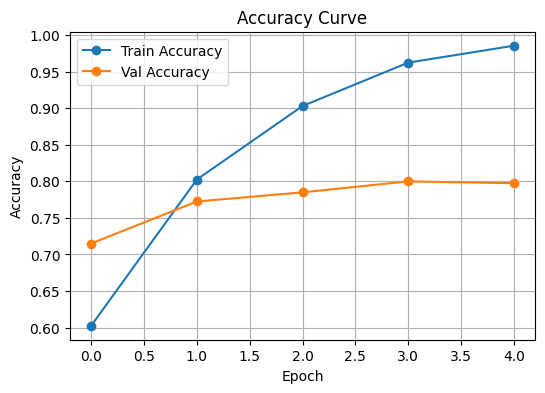

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_accuracies, label="Train Accuracy", marker="o")
plt.plot(val_accuracies, label="Val Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()


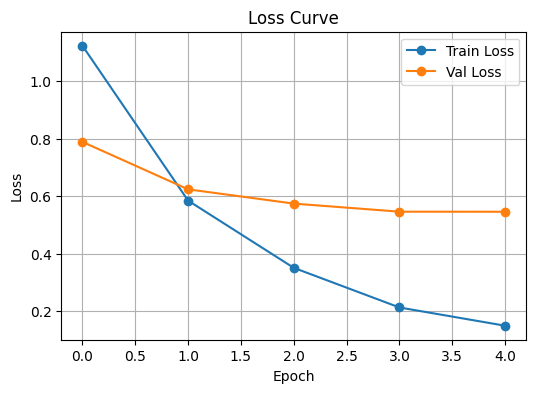

In [24]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


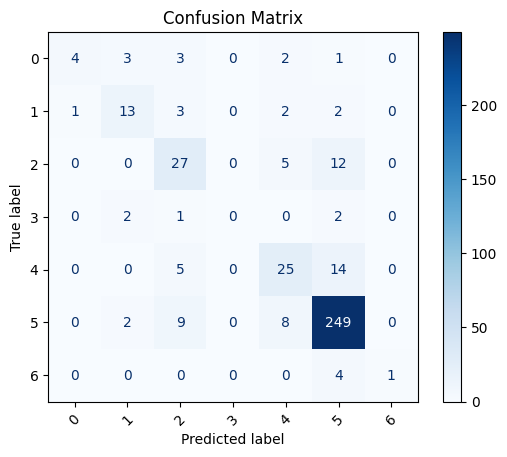

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Confusion Matrix"):
        images = images.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1).cpu()

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [26]:
def predict_with_confidence(image_tensor):
    model.eval()
    with torch.no_grad():
        logits = model(image_tensor.unsqueeze(0).to(device)).logits
        probs = torch.softmax(logits, dim=1)
        confidence, pred = torch.max(probs, dim=1)

    return pred.item(), confidence.item()


In [27]:
torch.save(model.state_dict(), "vit_skin_disease.pth")
print("Model saved successfully")


Model saved successfully
